# Read the pixel data from the binary sample files and use the data for inference
This should be the way that the micro-controller can run inference 
The binary sample files must be stored on the micro-controller file system or they must be converted to C++ source and include files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tflite_runtime.interpreter as tflite

2025-09-22 10:18:07.535737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-22 10:18:07.535843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-22 10:18:07.602774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-22 10:18:07.741273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 10:18:09.421101: W tensorflow/compiler/tf2

In [3]:
interpreter = tflite.Interpreter(model_path="models/number_model_quant.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
pixel_array = [None]*10
for img in range(10):
    filename = "esp32/bin_samples/sample{:d}.bin".format(img)
    f = open(filename,"rb")
    pixels = f.read()
    f.close()
    pixel_array[img] = np.frombuffer(pixels,dtype=np.int8)
    # reshape the array to (28,28)
    pixel_array[img] = pixel_array[img].reshape(28,28)
    # pixel_array[img].astype(np.float32)
    pixel_array[img] = pixel_array[img]
    print("min and max pixel values: {:d}, {:d}".format(pixel_array[img].min(),pixel_array[img].max()))

min and max pixel values: -128, 126
min and max pixel values: -128, 126
min and max pixel values: -128, 126
min and max pixel values: -128, 126
min and max pixel values: -128, 126
min and max pixel values: -128, 126
min and max pixel values: -128, 126
min and max pixel values: -128, 126
min and max pixel values: -128, 126
min and max pixel values: -128, 126


Let's try to plot the images

<Figure size 640x480 with 0 Axes>

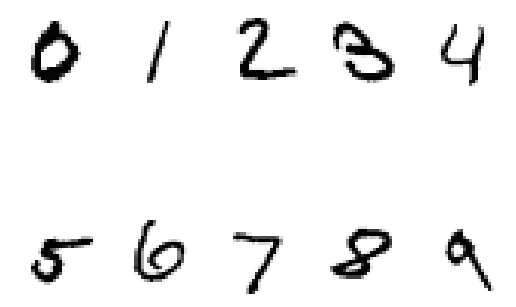

In [5]:
plt.set_cmap('Greys')
fig, axs = plt.subplots(2,5)
for i in range(2):
    for j in range(5):
        axs[i,j].axis('off')
        axs[i,j].imshow((pixel_array[5*i+j]).reshape(28,28))

Get the input and output details frrom the interpreter

In [6]:
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [7]:
print(input_details)
print()
print(output_details)

{'name': 'serving_default_fixed_input:0', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'shape_signature': array([ 1, 28, 28], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

{'name': 'StatefulPartitionedCall:0', 'index': 26, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [8]:
print("shape and data type: ",input_details["shape"],input_details["dtype"])
print("pixel data shape: ",pixel_array[0].shape)

shape and data type:  [ 1 28 28] <class 'numpy.int8'>
pixel data shape:  (28, 28)


So, we will have to reshape the pixel data

In [9]:
for img in range(10):
    pixel_array[img] = pixel_array[img].reshape(1,28,28)
print("New pixel_array shape: ",pixel_array[0].shape)
print("pixel array data type: ",pixel_array[0].dtype)

New pixel_array shape:  (1, 28, 28)
pixel array data type:  int8


In [10]:
interpreter.set_tensor(input_details['index'],pixel_array[0])
interpreter.invoke()
output = interpreter.get_tensor(output_details['index'])
print(output)

[[ 123 -128 -128 -128 -128 -127 -124 -128 -128 -128]]


Now we are ready to pass these data to the interpreter and invoke inference

In [11]:
output_data = [None]*10
for img in range(10):
    interpreter.set_tensor(input_details['index'],pixel_array[img])
    interpreter.invoke()
    output_data[img] = interpreter.get_tensor(output_details['index']).reshape(10,)

Let's get at the output data and see it we found the correct digit

In [12]:
print("outputs from interpreter invocations")
for img in range(10):
    print(output_data[img])

outputs from interpreter invocations
[ 126 -128 -128 -127 -128 -128 -128 -128 -128 -127]
[-128  127 -128 -128 -128 -128 -128 -128 -128 -128]
[-128 -128  127 -128 -128 -128 -128 -128 -128 -128]
[-128 -128 -123  119 -128 -128 -128 -128 -125 -128]
[-128 -128 -128 -128  127 -128 -128 -128 -128 -128]
[-128 -128 -128 -128 -128  127 -128 -128 -128 -128]
[-126 -128 -128 -128 -128 -128  126 -128 -128 -128]
[-128 -128 -128 -128 -128 -128 -128  127 -128 -128]
[-128 -128 -128 -128 -128 -128 -128 -128  127 -128]
[-128 -128 -127 -125 -128 -128 -128 -128 -128  124]


Dequantize the results

In [13]:
output_quantization_parameters = output_details["quantization_parameters"]
output_scale, output_zero_point = output_quantization_parameters["scales"][0], output_quantization_parameters["zero_points"][0]
probability = [None]*10
for img in range(10):
    probability[img] = output_scale * (output_data[img].astype("float") - output_zero_point)
    for i in range(10):
        print("{:8.6f}".format(probability[img][i]), end=" ")
    print()

0.992188 0.000000 0.000000 0.003906 0.000000 0.000000 0.000000 0.000000 0.000000 0.003906 
0.000000 0.996094 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.996094 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.019531 0.964844 0.000000 0.000000 0.000000 0.000000 0.011719 0.000000 
0.000000 0.000000 0.000000 0.000000 0.996094 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.996094 0.000000 0.000000 0.000000 0.000000 
0.007812 0.000000 0.000000 0.000000 0.000000 0.000000 0.992188 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.996094 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.996094 0.000000 
0.000000 0.000000 0.003906 0.011719 0.000000 0.000000 0.000000 0.000000 0.000000 0.984375 


In [14]:
for img in range(10):
    print("Digit found: ", probability[img].argmax())

Digit found:  0
Digit found:  1
Digit found:  2
Digit found:  3
Digit found:  4
Digit found:  5
Digit found:  6
Digit found:  7
Digit found:  8
Digit found:  9


In [15]:
for img in range(10):
    sum = 0
    for i in range(10):
        sum += probability[img][i]
    print("Total of probabilities: {:f}",sum)

Total of probabilities: {:f} 1.0
Total of probabilities: {:f} 0.99609375
Total of probabilities: {:f} 0.99609375
Total of probabilities: {:f} 0.99609375
Total of probabilities: {:f} 0.99609375
Total of probabilities: {:f} 0.99609375
Total of probabilities: {:f} 1.0
Total of probabilities: {:f} 0.99609375
Total of probabilities: {:f} 0.99609375
Total of probabilities: {:f} 1.0


In [16]:
for img in range(10):
    probability[img] = (output_data[img] + 128) / 255
    for j in range(10):
        print("{:8.6f}".format(probability[img][j]), end=" ")
    print("")        

0.996078 0.000000 0.000000 0.003922 0.000000 0.000000 0.000000 0.000000 0.000000 0.003922 
0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.019608 0.968627 0.000000 0.000000 0.000000 0.000000 0.011765 0.000000 
0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 
0.007843 0.000000 0.000000 0.000000 0.000000 0.000000 0.996078 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 
0.000000 0.000000 0.003922 0.011765 0.000000 0.000000 0.000000 0.000000 0.000000 0.988235 


In [17]:
for img in range(10):
    sum = 0
    for i in range(10):
        sum += probability[img][i]
    print("Total of probabilities: {:f}".format(sum))

Total of probabilities: 1.003922
Total of probabilities: 1.000000
Total of probabilities: 1.000000
Total of probabilities: 1.000000
Total of probabilities: 1.000000
Total of probabilities: 1.000000
Total of probabilities: 1.003922
Total of probabilities: 1.000000
Total of probabilities: 1.000000
Total of probabilities: 1.003922


Plot the confusion matrix

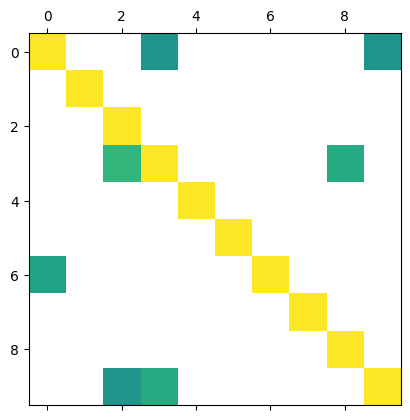

In [18]:
from matplotlib import colors as colors
plt.matshow(probability,norm=colors.LogNorm(0.00001,1), cmap="viridis")